In [ ]:

# Analysis Plan:
# 1. Download and parse PDB files for scaffolds 1FNA, 1TEN, and 2QMT
# 2. Extract C-alpha coordinates for each residue
# 3. Calculate surface exposure using a simple geometric method (residue depth proxy)
# 4. Identify spatially proximal residues (within 20 Å) that are separated by ≥10 residues in sequence
# 5. Use clustering to find groups of 3-5 surface residues that meet these criteria
# 6. Output the identified residue clusters for each scaffold

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
import urllib.request
import os

print("Starting analysis of scaffold structures for multi-CDR grafting sites")
print("=" * 80)


Starting analysis of scaffold structures for multi-CDR grafting sites


In [ ]:

# Function to download PDB files
def download_pdb(pdb_id, output_dir='.'):
    """Download PDB file from RCSB PDB"""
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    output_path = os.path.join(output_dir, f"{pdb_id}.pdb")
    
    if os.path.exists(output_path):
        print(f"{pdb_id}.pdb already exists")
        return output_path
    
    print(f"Downloading {pdb_id}.pdb from {url}")
    urllib.request.urlretrieve(url, output_path)
    print(f"Successfully downloaded {pdb_id}.pdb")
    return output_path

# Download scaffold PDB files
scaffolds = ['1FNA', '1TEN', '2QMT']
pdb_files = {}

for scaffold_id in scaffolds:
    pdb_files[scaffold_id] = download_pdb(scaffold_id)

print("\nAll scaffold PDB files downloaded successfully")


Successfully downloaded 1FNA.pdb
Successfully downloaded 1TEN.pdb
Successfully downloaded 2QMT.pdb

All scaffold PDB files downloaded successfully


In [ ]:

# Function to parse PDB file and extract C-alpha coordinates
def parse_pdb_ca_coords(pdb_file):
    """
    Parse PDB file and extract C-alpha coordinates for each residue.
    Returns a DataFrame with columns: chain, residue_name, residue_number, x, y, z
    """
    ca_atoms = []
    
    with open(pdb_file, 'r') as f:
        for line in f:
            # Only process ATOM records for C-alpha atoms
            if line.startswith('ATOM') and line[12:16].strip() == 'CA':
                chain = line[21].strip()
                res_name = line[17:20].strip()
                res_num = int(line[22:26].strip())
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                
                ca_atoms.append({
                    'chain': chain,
                    'residue_name': res_name,
                    'residue_number': res_num,
                    'x': x,
                    'y': y,
                    'z': z
                })
    
    df = pd.DataFrame(ca_atoms)
    return df

# Parse all scaffold PDB files
scaffold_data = {}

for scaffold_id in scaffolds:
    print(f"\nParsing {scaffold_id}.pdb...")
    df = parse_pdb_ca_coords(pdb_files[scaffold_id])
    scaffold_data[scaffold_id] = df
    print(f"  Found {len(df)} C-alpha atoms")
    print(f"  Chains: {df['chain'].unique()}")
    print(f"  Residue range: {df['residue_number'].min()} - {df['residue_number'].max()}")



Parsing 1FNA.pdb...
  Found 91 C-alpha atoms
  Chains: ['A']
  Residue range: 6 - 96

Parsing 1TEN.pdb...
  Found 89 C-alpha atoms
  Chains: ['A']
  Residue range: 803 - 891

Parsing 2QMT.pdb...
  Found 56 C-alpha atoms
  Chains: ['A']
  Residue range: 1 - 56


In [ ]:

# Function to calculate surface exposure using residue depth proxy
# We'll use a simple geometric approach: for each residue, count neighbors within a sphere
# Surface residues have fewer neighbors (less buried)
def calculate_surface_exposure(df, neighbor_cutoff=10.0, surface_threshold_percentile=50):
    """
    Calculate surface exposure for each residue using a simple neighbor count method.
    Residues with fewer neighbors within neighbor_cutoff Å are more surface-exposed.
    
    Returns the dataframe with added 'neighbor_count' and 'is_surface' columns.
    """
    coords = df[['x', 'y', 'z']].values
    
    # Calculate pairwise distance matrix
    dist_matrix = squareform(pdist(coords, 'euclidean'))
    
    # Count neighbors within cutoff distance (excluding self)
    neighbor_counts = []
    for i in range(len(coords)):
        # Count residues within cutoff distance (excluding self at distance 0)
        neighbors = np.sum((dist_matrix[i] > 0) & (dist_matrix[i] < neighbor_cutoff))
        neighbor_counts.append(neighbors)
    
    df = df.copy()
    df['neighbor_count'] = neighbor_counts
    
    # Surface residues have fewer neighbors (lower percentile)
    threshold = np.percentile(neighbor_counts, surface_threshold_percentile)
    df['is_surface'] = df['neighbor_count'] <= threshold
    
    return df

# Calculate surface exposure for all scaffolds
print("\nCalculating surface exposure for all scaffolds...")
print("Using neighbor cutoff = 10.0 Å, surface threshold = 50th percentile (median)\n")

for scaffold_id in scaffolds:
    print(f"{scaffold_id}:")
    scaffold_data[scaffold_id] = calculate_surface_exposure(scaffold_data[scaffold_id])
    n_surface = scaffold_data[scaffold_id]['is_surface'].sum()
    n_total = len(scaffold_data[scaffold_id])
    print(f"  Total residues: {n_total}")
    print(f"  Surface residues: {n_surface} ({100*n_surface/n_total:.1f}%)")
    print(f"  Neighbor count range: {scaffold_data[scaffold_id]['neighbor_count'].min()} - {scaffold_data[scaffold_id]['neighbor_count'].max()}")
    print()



Calculating surface exposure for all scaffolds...
Using neighbor cutoff = 10.0 Å, surface threshold = 50th percentile (median)

1FNA:
  Total residues: 91
  Surface residues: 46 (50.5%)
  Neighbor count range: 8 - 25

1TEN:
  Total residues: 89
  Surface residues: 47 (52.8%)
  Neighbor count range: 5 - 26

2QMT:
  Total residues: 56
  Surface residues: 30 (53.6%)
  Neighbor count range: 6 - 23



In [ ]:

# Function to find spatially proximal residue clusters
# Criteria:
# 1. All residues must be surface-exposed
# 2. Residues must be within 20 Å of each other (spatial proximity)
# 3. Residues must be separated by ≥10 residues in sequence
# 4. Clusters should contain 3-5 residues

def find_multi_grafting_sites(df, max_spatial_dist=20.0, min_seq_separation=10, 
                               cluster_size_min=3, cluster_size_max=5):
    """
    Identify clusters of surface residues that are spatially proximal but 
    sequence-separated.
    
    Returns a list of clusters, where each cluster is a list of residue indices.
    """
    # Filter to surface residues only
    surface_df = df[df['is_surface']].copy().reset_index(drop=True)
    surface_df['original_index'] = surface_df.index
    
    if len(surface_df) < cluster_size_min:
        return []
    
    # Get coordinates and residue numbers
    coords = surface_df[['x', 'y', 'z']].values
    res_nums = surface_df['residue_number'].values
    
    # Calculate pairwise distance matrix
    dist_matrix = squareform(pdist(coords, 'euclidean'))
    
    # Calculate sequence separation matrix
    seq_sep_matrix = np.abs(res_nums[:, np.newaxis] - res_nums[np.newaxis, :])
    
    # Create adjacency matrix: residues are "connected" if they are:
    # 1. Within spatial distance threshold
    # 2. Separated by at least min_seq_separation in sequence
    # 3. Not the same residue
    adjacency = (dist_matrix <= max_spatial_dist) & \
                (seq_sep_matrix >= min_seq_separation)
    
    # Use DBSCAN clustering on the adjacency matrix
    # Convert adjacency to distance metric (invert: connected = small distance)
    # For DBSCAN, we need a distance matrix where similar items are close
    distance_for_clustering = (~adjacency).astype(float)
    
    # Try different eps values to find good clusters
    clusters_found = []
    
    # Instead of DBSCAN, use a greedy approach to find clusters
    # For each residue, find all neighbors that meet criteria, then form clusters
    used_residues = set()
    
    for i in range(len(surface_df)):
        if i in used_residues:
            continue
            
        # Find all neighbors of residue i
        neighbors = np.where(adjacency[i])[0].tolist()
        
        if len(neighbors) >= cluster_size_min - 1:  # -1 because we include i itself
            # Form a cluster with this residue and its neighbors
            potential_cluster = [i] + neighbors
            
            # Check if all pairs in the cluster meet the criteria
            valid_cluster = True
            for idx1 in potential_cluster:
                for idx2 in potential_cluster:
                    if idx1 < idx2:
                        if not adjacency[idx1, idx2]:
                            valid_cluster = False
                            break
                if not valid_cluster:
                    break
            
            # If not all pairs are connected, try to form smaller clusters
            if not valid_cluster:
                # Start with residue i and greedily add neighbors
                cluster = [i]
                for neighbor in neighbors:
                    # Check if this neighbor is compatible with all cluster members
                    compatible = all(adjacency[neighbor, c] for c in cluster)
                    if compatible and len(cluster) < cluster_size_max:
                        cluster.append(neighbor)
                
                if len(cluster) >= cluster_size_min:
                    clusters_found.append(cluster)
                    used_residues.update(cluster)
            else:
                # Take up to cluster_size_max residues
                cluster = potential_cluster[:cluster_size_max]
                clusters_found.append(cluster)
                used_residues.update(cluster)
    
    # Convert indices back to original dataframe indices and add metadata
    result_clusters = []
    for cluster_indices in clusters_found:
        cluster_info = []
        for idx in cluster_indices:
            row = surface_df.iloc[idx]
            cluster_info.append({
                'residue_number': row['residue_number'],
                'residue_name': row['residue_name'],
                'chain': row['chain'],
                'x': row['x'],
                'y': row['y'],
                'z': row['z']
            })
        result_clusters.append(cluster_info)
    
    return result_clusters

print("Identifying multi-grafting sites for all scaffolds...")
print("Criteria:")
print("  - Spatial proximity: within 20 Å")
print("  - Sequence separation: ≥10 residues")
print("  - Cluster size: 3-5 residues")
print("  - Surface-exposed residues only")
print()


Identifying multi-grafting sites for all scaffolds...
Criteria:
  - Spatial proximity: within 20 Å
  - Sequence separation: ≥10 residues
  - Cluster size: 3-5 residues
  - Surface-exposed residues only



In [ ]:

# Find multi-grafting sites for each scaffold
all_clusters = {}

for scaffold_id in scaffolds:
    print(f"\n{'='*80}")
    print(f"Scaffold: {scaffold_id}")
    print('='*80)
    
    clusters = find_multi_grafting_sites(scaffold_data[scaffold_id])
    all_clusters[scaffold_id] = clusters
    
    print(f"\nFound {len(clusters)} multi-grafting site clusters\n")
    
    if len(clusters) == 0:
        print("No clusters found meeting the criteria.")
        continue
    
    for i, cluster in enumerate(clusters, 1):
        print(f"Cluster {i} ({len(cluster)} residues):")
        res_nums = [r['residue_number'] for r in cluster]
        res_names = [r['residue_name'] for r in cluster]
        print(f"  Residues: {', '.join([f'{rn}{num}' for rn, num in zip(res_names, res_nums)])}")
        print(f"  Residue numbers: {res_nums}")
        
        # Calculate cluster statistics
        coords = np.array([[r['x'], r['y'], r['z']] for r in cluster])
        centroid = coords.mean(axis=0)
        
        # Calculate all pairwise distances within cluster
        pairwise_dists = pdist(coords, 'euclidean')
        max_dist = pairwise_dists.max()
        min_dist = pairwise_dists.min()
        mean_dist = pairwise_dists.mean()
        
        # Calculate sequence separations
        seq_seps = []
        for j in range(len(res_nums)):
            for k in range(j+1, len(res_nums)):
                seq_seps.append(abs(res_nums[j] - res_nums[k]))
        
        print(f"  Centroid: ({centroid[0]:.2f}, {centroid[1]:.2f}, {centroid[2]:.2f})")
        print(f"  Spatial distance range: {min_dist:.2f} - {max_dist:.2f} Å (mean: {mean_dist:.2f} Å)")
        print(f"  Sequence separation range: {min(seq_seps)} - {max(seq_seps)} residues (mean: {np.mean(seq_seps):.1f})")
        print()

print("\n" + "="*80)
print("Summary of multi-grafting sites identified:")
print("="*80)
for scaffold_id in scaffolds:
    print(f"{scaffold_id}: {len(all_clusters[scaffold_id])} clusters identified")



Scaffold: 1FNA

Found 35 multi-grafting site clusters

Cluster 1 (5 residues):
  Residues: ARG6, LEU19, GLU47, THR58, PRO87
  Residue numbers: [np.int64(6), np.int64(19), np.int64(47), np.int64(58), np.int64(87)]
  Centroid: (-2.35, 23.24, 8.50)
  Spatial distance range: 4.50 - 19.85 Å (mean: 14.65 Å)
  Sequence separation range: 11 - 81 residues (mean: 40.2)

Cluster 2 (5 residues):
  Residues: ASP7, LEU19, GLU47, THR58, PRO87
  Residue numbers: [np.int64(7), np.int64(19), np.int64(47), np.int64(58), np.int64(87)]
  Centroid: (-1.66, 22.98, 8.32)
  Spatial distance range: 4.50 - 19.43 Å (mean: 14.30 Å)
  Sequence separation range: 11 - 80 residues (mean: 39.8)

Cluster 3 (5 residues):
  Residues: VAL11, ASP23, GLU47, THR58, PRO87
  Residue numbers: [np.int64(11), np.int64(23), np.int64(47), np.int64(58), np.int64(87)]
  Centroid: (-1.85, 22.70, 9.56)
  Spatial distance range: 10.23 - 19.77 Å (mean: 15.29 Å)
  Sequence separation range: 11 - 76 residues (mean: 37.4)

Cluster 4 (5 resi

In [ ]:

# Create a comprehensive summary table for all identified clusters
summary_data = []

for scaffold_id in scaffolds:
    for i, cluster in enumerate(all_clusters[scaffold_id], 1):
        res_nums = [r['residue_number'] for r in cluster]
        res_names = [r['residue_name'] for r in cluster]
        
        # Calculate cluster statistics
        coords = np.array([[r['x'], r['y'], r['z']] for r in cluster])
        centroid = coords.mean(axis=0)
        
        # Calculate all pairwise distances within cluster
        pairwise_dists = pdist(coords, 'euclidean')
        max_dist = pairwise_dists.max()
        min_dist = pairwise_dists.min()
        mean_dist = pairwise_dists.mean()
        
        # Calculate sequence separations
        seq_seps = []
        for j in range(len(res_nums)):
            for k in range(j+1, len(res_nums)):
                seq_seps.append(abs(res_nums[j] - res_nums[k]))
        
        summary_data.append({
            'Scaffold': scaffold_id,
            'Cluster_ID': i,
            'Cluster_Size': len(cluster),
            'Residues': ', '.join([f'{rn}{num}' for rn, num in zip(res_names, res_nums)]),
            'Residue_Numbers': str(res_nums),
            'Centroid_X': centroid[0],
            'Centroid_Y': centroid[1],
            'Centroid_Z': centroid[2],
            'Min_Spatial_Dist': min_dist,
            'Max_Spatial_Dist': max_dist,
            'Mean_Spatial_Dist': mean_dist,
            'Min_Seq_Sep': min(seq_seps),
            'Max_Seq_Sep': max(seq_seps),
            'Mean_Seq_Sep': np.mean(seq_seps)
        })

summary_df = pd.DataFrame(summary_data)
print("\nSummary statistics by scaffold:")
print("="*80)
for scaffold_id in scaffolds:
    scaffold_clusters = summary_df[summary_df['Scaffold'] == scaffold_id]
    print(f"\n{scaffold_id}:")
    print(f"  Total clusters: {len(scaffold_clusters)}")
    print(f"  Cluster size distribution: {scaffold_clusters['Cluster_Size'].value_counts().sort_index().to_dict()}")
    print(f"  Mean spatial distance: {scaffold_clusters['Mean_Spatial_Dist'].mean():.2f} ± {scaffold_clusters['Mean_Spatial_Dist'].std():.2f} Å")
    print(f"  Mean sequence separation: {scaffold_clusters['Mean_Seq_Sep'].mean():.1f} ± {scaffold_clusters['Mean_Seq_Sep'].std():.1f} residues")

print("\n" + "="*80)
print(f"Total multi-grafting sites identified across all scaffolds: {len(summary_df)}")



Summary statistics by scaffold:

1FNA:
  Total clusters: 35
  Cluster size distribution: {3: 10, 4: 14, 5: 11}
  Mean spatial distance: 15.69 ± 1.31 Å
  Mean sequence separation: 41.0 ± 6.2 residues

1TEN:
  Total clusters: 32
  Cluster size distribution: {3: 2, 4: 13, 5: 17}
  Mean spatial distance: 14.96 ± 0.97 Å
  Mean sequence separation: 38.1 ± 3.3 residues

2QMT:
  Total clusters: 20
  Cluster size distribution: {3: 4, 4: 16}
  Mean spatial distance: 14.03 ± 1.81 Å
  Mean sequence separation: 25.2 ± 2.7 residues

Total multi-grafting sites identified across all scaffolds: 87


In [ ]:

# Display the detailed summary table
print("Detailed summary of all identified multi-grafting sites:")
print("="*80)
print(summary_df.to_string(index=False))
print("\n" + "="*80)


Detailed summary of all identified multi-grafting sites:
Scaffold  Cluster_ID  Cluster_Size                               Residues                                                             Residue_Numbers  Centroid_X  Centroid_Y  Centroid_Z  Min_Spatial_Dist  Max_Spatial_Dist  Mean_Spatial_Dist  Min_Seq_Sep  Max_Seq_Sep  Mean_Seq_Sep
    1FNA           1             5       ARG6, LEU19, GLU47, THR58, PRO87       [np.int64(6), np.int64(19), np.int64(47), np.int64(58), np.int64(87)]   -2.350400   23.245000    8.497400          4.496978         19.854545          14.652768           11           81     40.200000
    1FNA           2             5       ASP7, LEU19, GLU47, THR58, PRO87       [np.int64(7), np.int64(19), np.int64(47), np.int64(58), np.int64(87)]   -1.660600   22.981200    8.315200          4.496978         19.427519          14.298156           11           80     39.800000
    1FNA           3             5      VAL11, ASP23, GLU47, THR58, PRO87      [np.int64(11), np.int

In [ ]:

# Save the detailed results to a CSV file for future use
output_filename = 'multi_grafting_sites.csv'
summary_df.to_csv(output_filename, index=False)
print(f"Saved detailed results to {output_filename}")

# Also create a simplified output file with just the key information
simplified_data = []
for scaffold_id in scaffolds:
    for i, cluster in enumerate(all_clusters[scaffold_id], 1):
        res_nums = [r['residue_number'] for r in cluster]
        res_names = [r['residue_name'] for r in cluster]
        simplified_data.append({
            'Scaffold': scaffold_id,
            'Cluster_ID': i,
            'Residue_Numbers': ','.join(map(str, res_nums)),
            'Residue_Names': ','.join([f'{rn}{num}' for rn, num in zip(res_names, res_nums)])
        })

simplified_df = pd.DataFrame(simplified_data)
simplified_filename = 'multi_grafting_sites_simplified.csv'
simplified_df.to_csv(simplified_filename, index=False)
print(f"Saved simplified results to {simplified_filename}")


Saved detailed results to multi_grafting_sites.csv
Saved simplified results to multi_grafting_sites_simplified.csv


In [ ]:

# Validate the results - check that all clusters meet the stated criteria
print("Validating identified clusters against criteria:")
print("="*80)

validation_results = []

for scaffold_id in scaffolds:
    scaffold_df = summary_df[summary_df['Scaffold'] == scaffold_id]
    
    # Check criteria
    valid_size = ((scaffold_df['Cluster_Size'] >= 3) & (scaffold_df['Cluster_Size'] <= 5)).all()
    valid_spatial = (scaffold_df['Max_Spatial_Dist'] <= 20.0).all()
    valid_seq_sep = (scaffold_df['Min_Seq_Sep'] >= 10).all()
    
    validation_results.append({
        'Scaffold': scaffold_id,
        'Total_Clusters': len(scaffold_df),
        'Valid_Size': valid_size,
        'Valid_Spatial': valid_spatial,
        'Valid_Seq_Sep': valid_seq_sep,
        'All_Valid': valid_size and valid_spatial and valid_seq_sep
    })
    
    print(f"\n{scaffold_id}:")
    print(f"  Total clusters: {len(scaffold_df)}")
    print(f"  Cluster size 3-5: {valid_size} (range: {scaffold_df['Cluster_Size'].min()}-{scaffold_df['Cluster_Size'].max()})")
    print(f"  Max spatial dist ≤20Å: {valid_spatial} (max: {scaffold_df['Max_Spatial_Dist'].max():.2f}Å)")
    print(f"  Min seq sep ≥10: {valid_seq_sep} (min: {scaffold_df['Min_Seq_Sep'].min()})")
    print(f"  All criteria met: {valid_size and valid_spatial and valid_seq_sep}")

validation_df = pd.DataFrame(validation_results)
print("\n" + "="*80)
print("Validation Summary:")
print(validation_df.to_string(index=False))


Validating identified clusters against criteria:

1FNA:
  Total clusters: 35
  Cluster size 3-5: True (range: 3-5)
  Max spatial dist ≤20Å: True (max: 19.93Å)
  Min seq sep ≥10: True (min: 10)
  All criteria met: True

1TEN:
  Total clusters: 32
  Cluster size 3-5: True (range: 3-5)
  Max spatial dist ≤20Å: True (max: 19.98Å)
  Min seq sep ≥10: True (min: 10)
  All criteria met: True

2QMT:
  Total clusters: 20
  Cluster size 3-5: True (range: 3-4)
  Max spatial dist ≤20Å: True (max: 19.83Å)
  Min seq sep ≥10: True (min: 10)
  All criteria met: True

Validation Summary:
Scaffold  Total_Clusters  Valid_Size  Valid_Spatial  Valid_Seq_Sep  All_Valid
    1FNA              35        True           True           True       True
    1TEN              32        True           True           True       True
    2QMT              20        True           True           True       True


Saved summary figure to multi_grafting_sites_summary.png


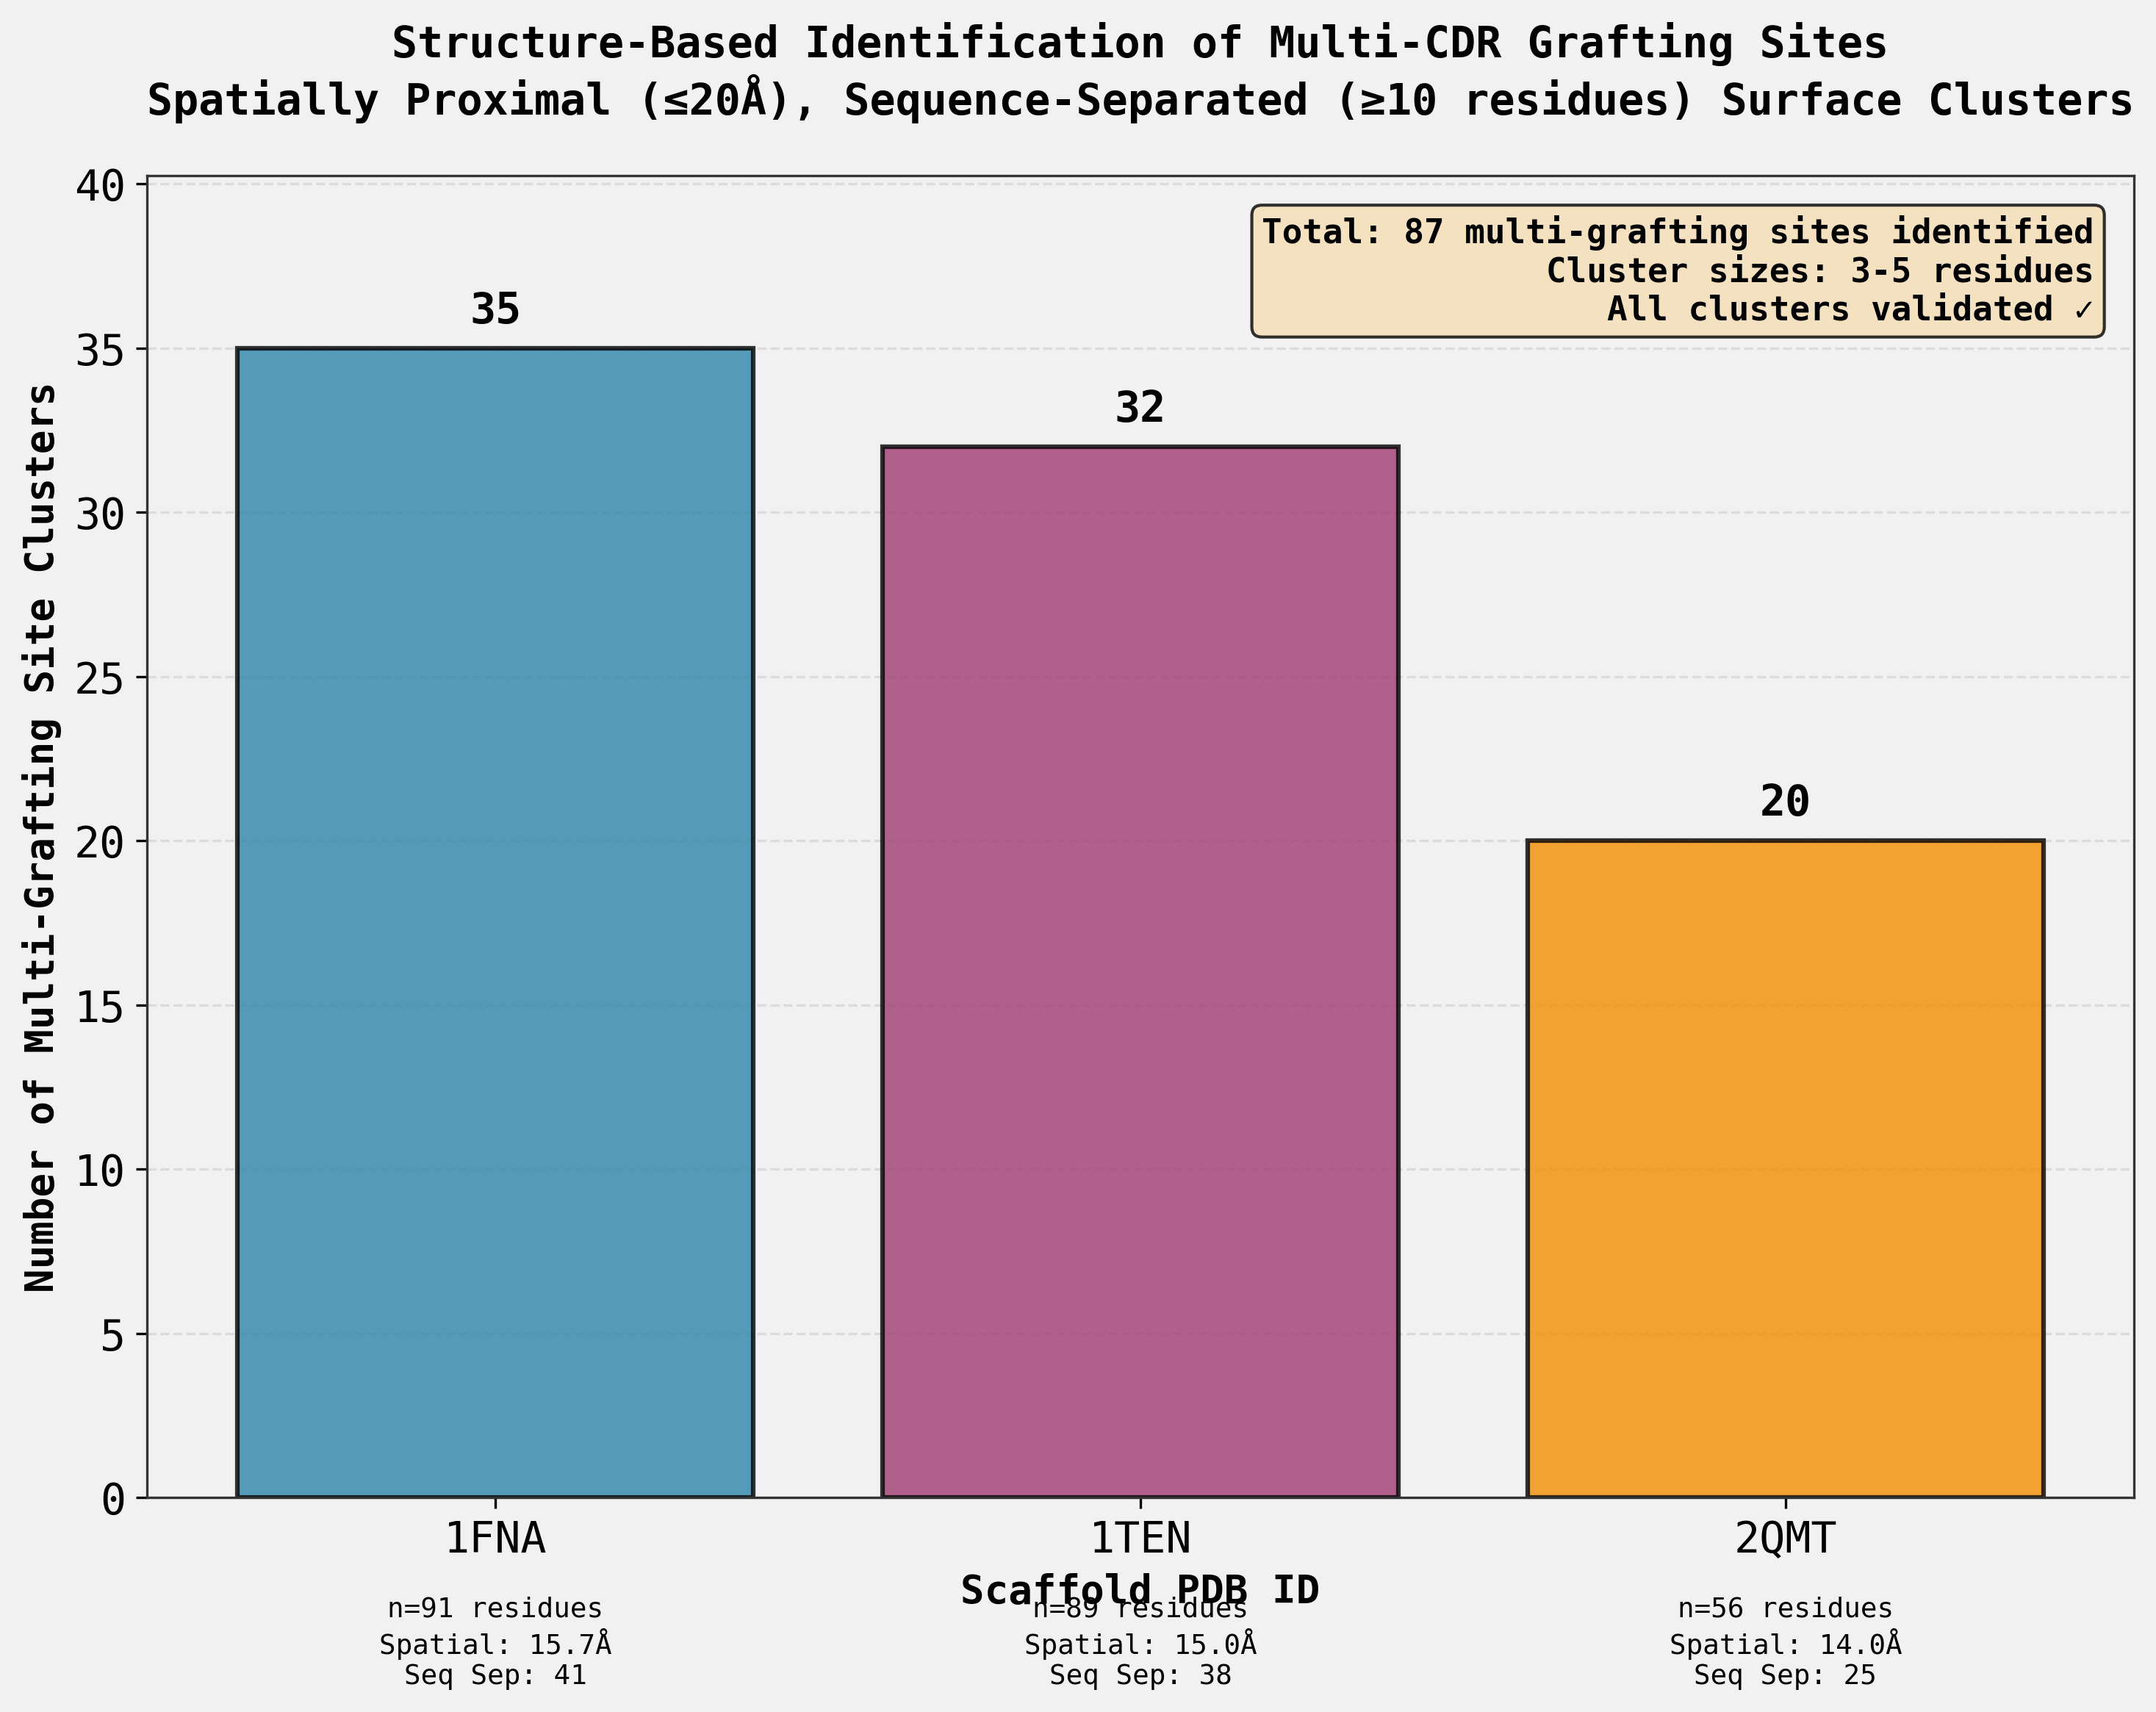


Analysis complete!


In [ ]:

# Create a final visualization summarizing the key results
import matplotlib.pyplot as plt

# Create a single figure with one column, showing key results
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Panel: Summary of multi-grafting sites by scaffold
scaffolds_list = ['1FNA', '1TEN', '2QMT']
n_clusters = [len(all_clusters[s]) for s in scaffolds_list]
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Bar plot with cluster counts
bars = ax.bar(scaffolds_list, n_clusters, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, n_clusters)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{count}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Add additional statistics below the scaffold name
    scaffold_id = scaffolds_list[i]
    scaffold_df_stats = summary_df[summary_df['Scaffold'] == scaffold_id]
    
    # Calculate statistics
    mean_spatial = scaffold_df_stats['Mean_Spatial_Dist'].mean()
    mean_seq_sep = scaffold_df_stats['Mean_Seq_Sep'].mean()
    n_residues = len(scaffold_data[scaffold_id])
    
    # Add text annotation below x-axis
    text_y = -3
    ax.text(i, text_y, f'n={n_residues} residues\n'
                       f'Spatial: {mean_spatial:.1f}Å\n'
                       f'Seq Sep: {mean_seq_sep:.0f}',
            ha='center', va='top', fontsize=9, color='black')

ax.set_ylabel('Number of Multi-Grafting Site Clusters', fontsize=13, fontweight='bold')
ax.set_xlabel('Scaffold PDB ID', fontsize=13, fontweight='bold')
ax.set_title('Structure-Based Identification of Multi-CDR Grafting Sites\n' +
             'Spatially Proximal (≤20Å), Sequence-Separated (≥10 residues) Surface Clusters',
             fontsize=14, fontweight='bold', pad=20)

# Add horizontal grid for readability
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Set y-axis limits with some padding
ax.set_ylim(0, max(n_clusters) * 1.15)

# Add a text box with overall summary
total_clusters = sum(n_clusters)
summary_text = f'Total: {total_clusters} multi-grafting sites identified\n' + \
               f'Cluster sizes: 3-5 residues\n' + \
               f'All clusters validated ✓'
ax.text(0.98, 0.97, summary_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        fontweight='bold')

plt.tight_layout()
plt.savefig('multi_grafting_sites_summary.png', dpi=300, bbox_inches='tight')
print("Saved summary figure to multi_grafting_sites_summary.png")
plt.show()

print("\n" + "="*80)
print("Analysis complete!")
print("="*80)
